In [462]:
import numpy as np
from smt.surrogate_models import KRG, RBF
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
import keras
from keras import layers
import keras_tuner


In [463]:
def read_data(type, folder, length):
    df = pd.DataFrame()
    parameters = pd.read_csv('Simulation_'+type+'/parameters_v1.txt')
    for i in range(length):
        new_data = pd.read_csv('Simulation_'+type+'/'+folder+'/'+type+'_X_data.csv/'+type+'_'+str(i+1)+'_data.csv')
        mean_force = new_data['FKN'].mean()
        max_force = new_data['FKN'].max()
        new_data_df = pd.DataFrame()
        new_data_df['mean_force'] = [mean_force]
        new_data_df['max_force'] = [max_force]
        for parameter in parameters.columns:
            new_data_df[parameter] = parameters[parameter][i]
        df = pd.concat([df, new_data_df])
    df = df.drop(columns=['sample'])
    df.reset_index(drop=True, inplace=True)

    return df

df = read_data(type='CRUSHING', folder='CONSTANT_THICKNESS_100', length=100)

In [464]:
X = df[['outer_wall_thickness', 'inside_wall_side_thickness', 'inside_wall_middle_thickness', 'height', 'width', 'sigma0', 'youngs']].values
Y = df[['max_force']].values

In [465]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)
Y_train = Y_train.ravel()
Y_val = Y_val.ravel()
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [478]:
C_values = np.linspace(1, 1000, num=100)
epsilon_values = np.logspace(-4, 2, num=100)
gamma_values = np.logspace(-4, 3, num=100)
kernel_values = ['linear', 'rbf', 'sigmoid']

In [487]:
values = []
for i in range(100000):
    C = np.random.choice(C_values)
    epsilon = np.random.choice(epsilon_values)
    gamma = np.random.choice(gamma_values)
    kernel = np.random.choice(kernel_values)

    svr = SVR(kernel=kernel, C=C, epsilon=epsilon, gamma=gamma)
    svr.fit(X_train, Y_train)
    Y_pred = svr.predict(X_val)
    mse = mean_squared_error(Y_val, Y_pred)
    mape = mean_absolute_percentage_error(Y_val, Y_pred)
    values.append([mse, mape, epsilon, C, gamma, kernel])

In [486]:
values = np.array(values)
# Create a csv file of values
data = pd.DataFrame(values, columns=['mse', 'mape', 'epsilon', 'C', 'gamma', 'kernel'])
min_mse = data['mape'].min()
print("MAPE, for SVR:", format(round(float(min_mse), 4)*100,'.2f'), "%")
print("Best parameters for SVR:")
print("Epsilon:", format(round(float(data['epsilon'][data['mape'].idxmin()]), 2), '.2f'))
print("C:", format(float(data['C'][data['mape'].idxmin()]), '.0f'))
print("Gamma:", format(round(float(data['gamma'][data['mape'].idxmin()]), 3), '.3f'))
print("Kernel:", data['kernel'][data['mape'].idxmin()])
#data = data.sort_values(by='C')


MAPE, for SVR: 1.02 %
Best parameters for SVR:
Epsilon: 4.04
C: 102
Gamma: 32.745
Kernel: linear


In [ ]:
"""# Fit a polynomial of degree 2 (quadratic) or another degree based on the trend you observe
coefficients = np.polyfit(data['C'], np.log10(data['mse']), deg=100)  # Adjust 'deg' as needed
polynomial = np.poly1d(coefficients)

# Create a range of x-values for plotting the fitted line
x_values = np.linspace(data['C'].min(), data['C'].max(), 100)
y_values = 10**polynomial(x_values)  # Convert back from log10 if your y-axis is log-scale

# Calculate the minimum MSE and find corresponding C value
min_mse_index = data['mse'].idxmin()
min_c = data['C'][min_mse_index]
min_mse = data['mse'][min_mse_index]

# Existing plot code
plt.figure(figsize=(10, 6))
plt.plot(data['C'], data['mse'], lw=4)  # Existing line plot

# Highlight the minimum value with a red dot
plt.plot(min_c, min_mse, 'ro', markersize=12)  # s is the size of the dot
plt.annotate(f'({min_c:.0f}, {min_mse:.2f})', xy=(min_c, min_mse), xytext=(min_c-5, min_mse+0.004), fontsize=18)

# Set labels and title
plt.xlabel('C', fontsize=18)
plt.ylabel('MSE', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.yscale('log')
plt.grid(True)
plt.show()"""

"# Fit a polynomial of degree 2 (quadratic) or another degree based on the trend you observe\ncoefficients = np.polyfit(data['C'], np.log10(data['mse']), deg=100)  # Adjust 'deg' as needed\npolynomial = np.poly1d(coefficients)\n\n# Create a range of x-values for plotting the fitted line\nx_values = np.linspace(data['C'].min(), data['C'].max(), 100)\ny_values = 10**polynomial(x_values)  # Convert back from log10 if your y-axis is log-scale\n\n# Calculate the minimum MSE and find corresponding C value\nmin_mse_index = data['mse'].idxmin()\nmin_c = data['C'][min_mse_index]\nmin_mse = data['mse'][min_mse_index]\n\n# Existing plot code\nplt.figure(figsize=(10, 6))\nplt.plot(data['C'], data['mse'], lw=4)  # Existing line plot\n\n# Highlight the minimum value with a red dot\nplt.plot(min_c, min_mse, 'ro', markersize=12)  # s is the size of the dot\nplt.annotate(f'({min_c:.0f}, {min_mse:.2f})', xy=(min_c, min_mse), xytext=(min_c-5, min_mse+0.004), fontsize=18)\n\n# Set labels and title\nplt.xl

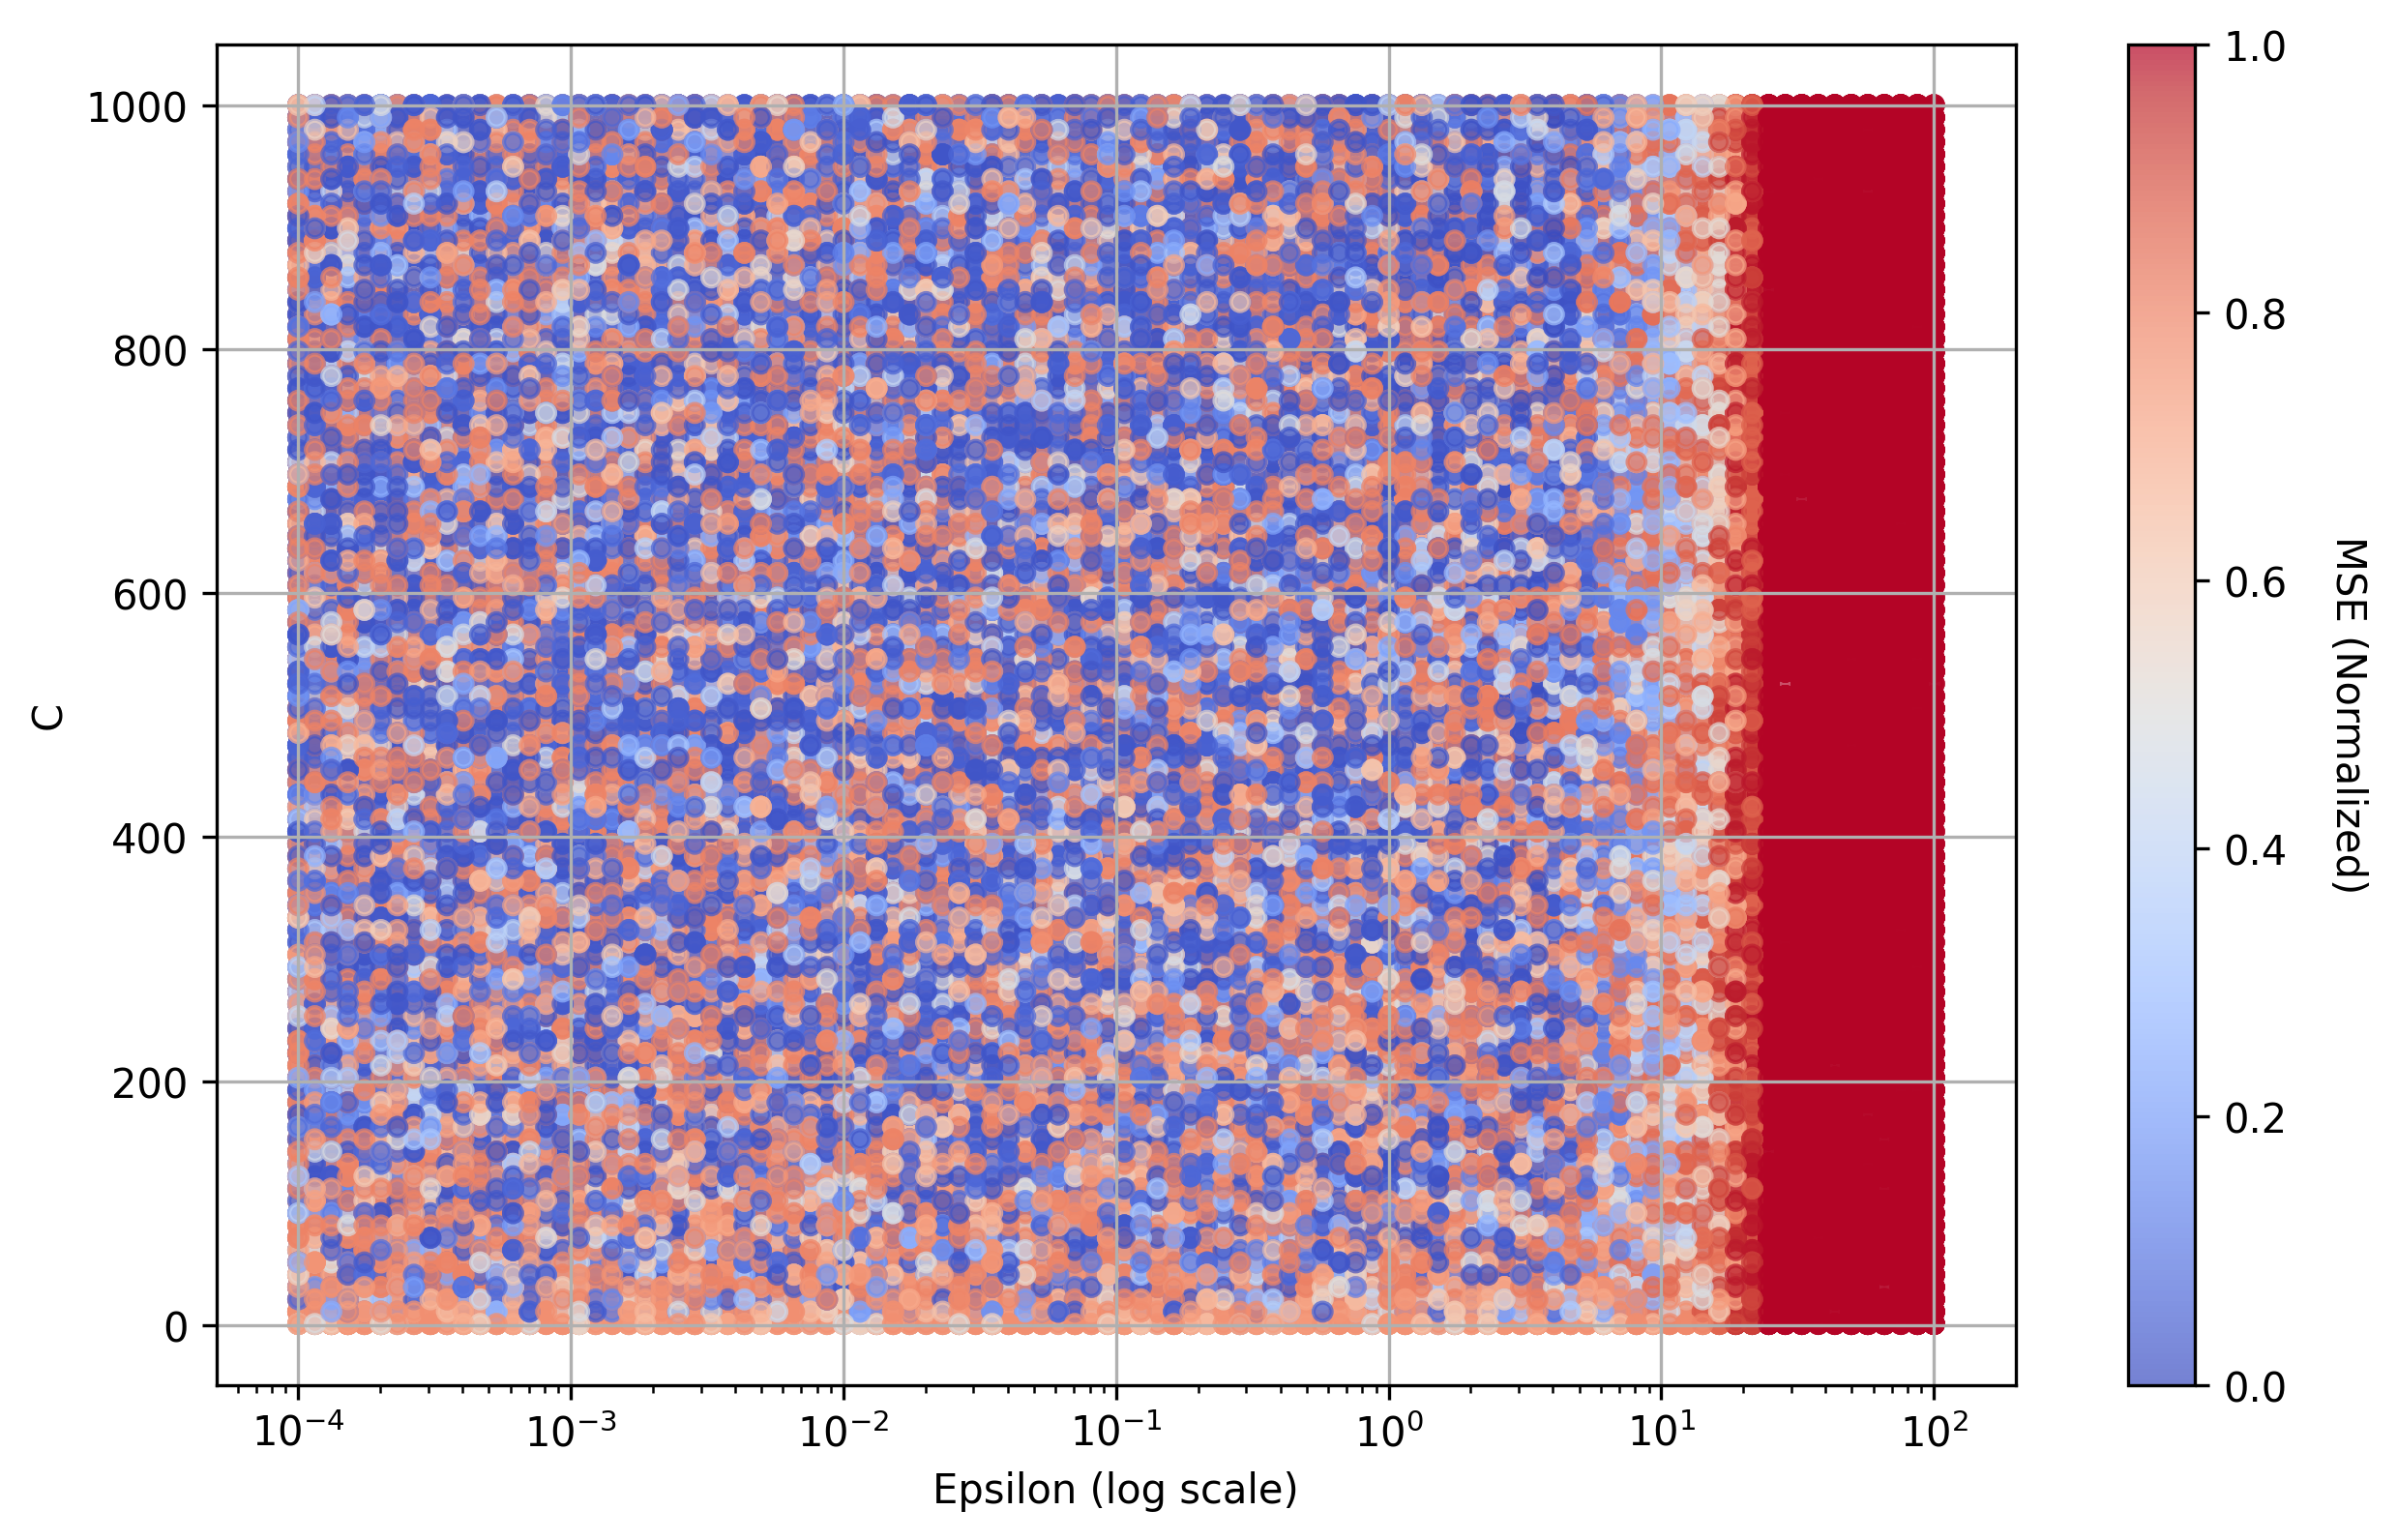

In [ ]:
# Normalize the 'mse' column for color mapping
mse_normalized = (data['mse'] - data['mse'].min()) / (data['mse'].max() - data['mse'].min())

# Create a colormap object
cmap = plt.cm.coolwarm  # Use any other colormap if you prefer

# Create a color map from blue to red using the colormap object
colors = cmap(mse_normalized)

# Plotting
plt.figure(figsize=(10, 6), dpi=300)
scatter = plt.scatter(data['epsilon'], data['C'], c=mse_normalized, cmap=cmap, alpha=0.7, s=20)
plt.xscale('log')  # Set the x-axis to a logarithmic scale
colorbar = plt.colorbar(scatter, label='MSE (Normalized)')  # Add a color bar to the plot to indicate color scale
colorbar.set_label('MSE (Normalized)', rotation=270, labelpad=20)
plt.xlabel('Epsilon (log scale)')  # Label for x-axis
plt.ylabel('C')  # Label for y-axis
plt.grid(True)  # Show grid lines
plt.show()  # Display the plot


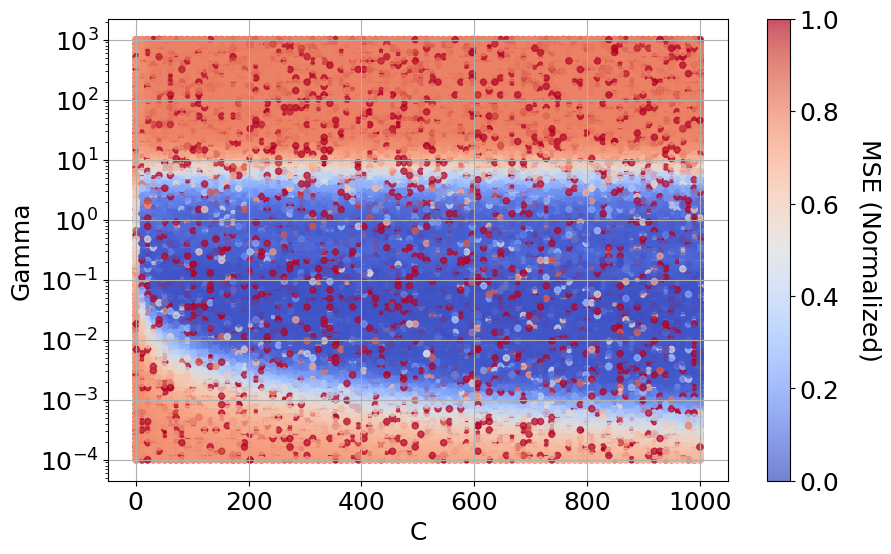

In [ ]:
# Normalize the 'mse' column for color mapping
mse_normalized = (data['mse'] - data['mse'].min()) / (data['mse'].max() - data['mse'].min())

# Create a colormap object
cmap = plt.cm.coolwarm  # Use any other colormap if you prefer

# Create a color map from blue to red using the colormap object
colors = cmap(mse_normalized)

# Plotting
plt.figure(figsize=(10, 6))
scatter = plt.scatter(data['C'], data['gamma'], c=mse_normalized, cmap=cmap, alpha=0.7, s=20)
plt.yscale('log')  # Set the y-axis to a logarithmic scale
colorbar = plt.colorbar(scatter, label='MSE (Normalized)')  # Add a color bar to the plot to indicate color scale
colorbar.set_label('MSE (Normalized)', rotation=270, labelpad=30, fontsize=18)  # Adjust fontsize as needed
for label in colorbar.ax.get_yticklabels():
    label.set_size(18)
plt.xlabel('C', fontsize=18)  # Label for x-axis
plt.ylabel('Gamma', fontsize=18)  # Label for y-axis
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True)  # Show grid lines
plt.show()  # Display the plot

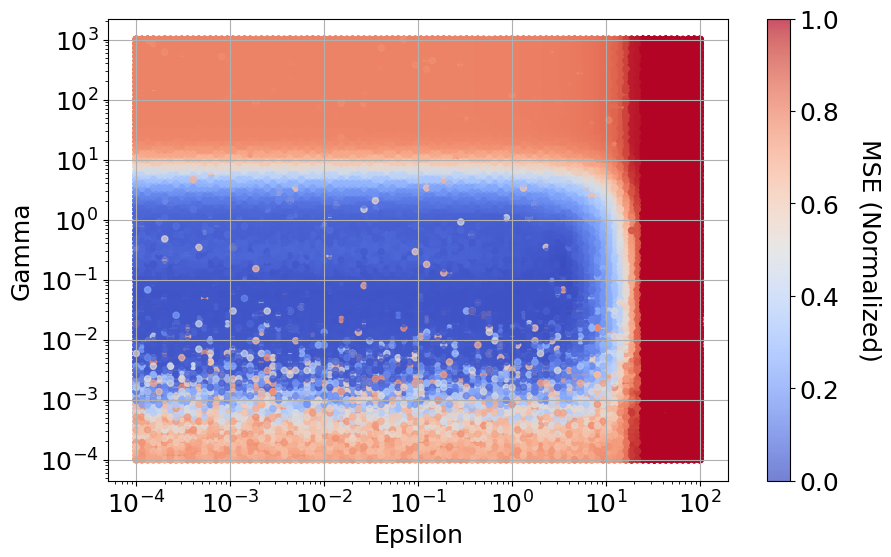

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Normalize the 'mse' column for color mapping
mse_normalized = (data['mse'] - data['mse'].min()) / (data['mse'].max() - data['mse'].min())

# Create a colormap object
cmap = plt.cm.coolwarm  # Use any other colormap if you prefer

# Create a color map from blue to red using the colormap object
colors = cmap(mse_normalized)

# Plotting
plt.figure(figsize=(10, 6))
scatter = plt.scatter(data['epsilon'], data['gamma'], c=mse_normalized, cmap=cmap, alpha=0.7, s=20)
plt.xscale('log')  # Set the x-axis to a logarithmic scale
plt.yscale('log')  # Set the x-axis to a logarithmic scale
colorbar = plt.colorbar(scatter, label='MSE (Normalized)')  # Add a color bar to the plot to indicate color scale
colorbar.set_label('MSE (Normalized)', rotation=270, labelpad=30, fontsize=18)  # Adjust fontsize as needed
for label in colorbar.ax.get_yticklabels():
    label.set_size(18)
plt.xlabel('Epsilon', fontsize=18)  # Label for x-axis
plt.ylabel('Gamma', fontsize=18)  # Label for y-axis
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True)  # Show grid lines
plt.show()  # Display the plot

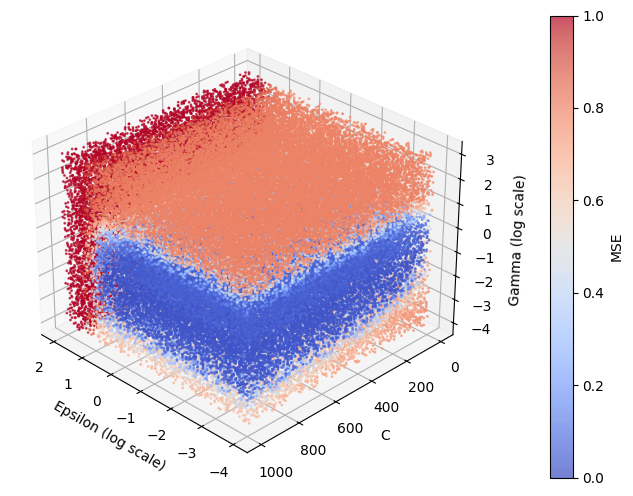

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Generating random data
x = data['epsilon']
y = data['C']
z = data['gamma']
mse_normalized = (data['mse'] - data['mse'].min()) / (data['mse'].max() - data['mse'].min())

# Applying logarithmic transformation
log_x = np.log10(x)
log_z = np.log10(z)

# Creating a figure
fig = plt.figure(figsize=(10, 6))

# Adding a subplot for 3D plot
ax = fig.add_subplot(111, projection='3d')

# Creating the scatter plot with transformed data
scatter = ax.scatter(log_x, y, log_z, c=mse_normalized, cmap='coolwarm', marker='o', s=1, alpha=0.7)

# Adding a color bar which maps values to colors
colorbar = plt.colorbar(scatter, ax=ax, label='MSE', pad=0.1)

# Setting labels
ax.set_xlabel('Epsilon (log scale)')
ax.set_ylabel('C')
ax.set_zlabel('Gamma (log scale)')

# Adjust the left margin
#plt.subplots_adjust(left=0.4)

# Setting the view angle
ax.view_init(elev=30, azim=135)

# Showing the plot
plt.show()



In [ ]:
"""space = dict()
space['C'] = np.linspace(1, 100, num=100)
space['epsilon'] = np.logspace(-3, 1, num=100)"""

"space = dict()\nspace['C'] = np.linspace(1, 100, num=100)\nspace['epsilon'] = np.logspace(-3, 1, num=100)"

In [ ]:
"""search = RandomizedSearchCV(
    estimator=SVR(kernel='rbf'), 
    param_distributions=space, 
    n_iter=1000, 
    scoring='neg_mean_squared_error', 
    n_jobs=-1,
    random_state=42
)"""

"search = RandomizedSearchCV(\n    estimator=SVR(kernel='rbf'), \n    param_distributions=space, \n    n_iter=1000, \n    scoring='neg_mean_squared_error', \n    n_jobs=-1,\n    random_state=42\n)"

In [ ]:
"""result = search.fit(X_train, Y_train)"""

'result = search.fit(X_train, Y_train)'

In [ ]:
"""print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)"""

"print('Best Score: %s' % result.best_score_)\nprint('Best Hyperparameters: %s' % result.best_params_)"

In [ ]:
SVR_model = SVR(kernel='rbf', C=92, gamma=0.028, epsilon=0.11)
#SVR_model = SVR(kernel='rbf', epsilon=0.01, C=50)
SVR_model.fit(X_train,Y_train)

SVR(C=92, epsilon=0.11, gamma=0.028)

In [ ]:
Y_predicted_SVR = SVR_model.predict(X_val)

In [ ]:
mse_SVR = mean_squared_error(Y_val, Y_predicted_SVR)
print("MSE, for SVR:", mse_SVR)


MSE, for SVR: 11.06397511039749


In [ ]:
mae_SVR = mean_absolute_error(Y_val, Y_predicted_SVR)
print("MAE, for SVR:", mae_SVR)

MAE, for SVR: 2.5886587987817293


In [ ]:
mape_SVR = mean_absolute_percentage_error(Y_val, Y_predicted_SVR)
print("MAPE, for SVR:", format(round(mape_SVR, 4)*100,'.2f'), "%")

MAPE, for SVR: 1.29 %


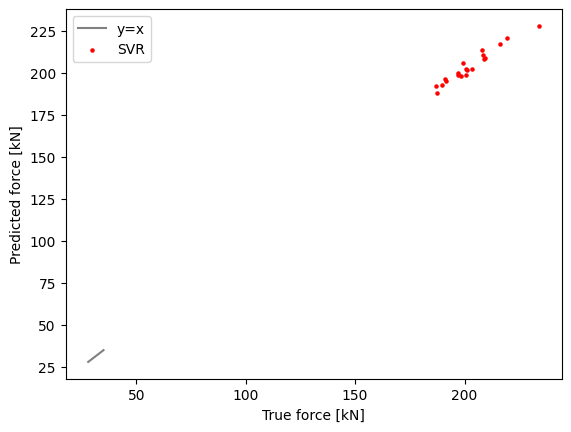

In [ ]:
plt.plot([28, 35], [28, 35], label='y=x', color='gray')

plt.scatter(Y_val,Y_predicted_SVR, s=5, label= 'SVR', color='red')

plt.xlabel('True force [kN]')
plt.ylabel('Predicted force [kN]')
plt.legend()